# FE 621: HW1
***
Name: Siddharth Iyer <br>
CWID: 10447455 <br>

Pledge: I pledge my honor that I have abided by the Stevens Honor System. 
***

In [1]:
# imports
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import norm

## Problem 1

**(a) Download price and implied volatility data for S&P 500 index options (SPX options). You also need the value of the S&P 500 index.
<br>
(b) Download the interest rate data from http://www.federalreserve.gov/releases/H15/Current/**

In [3]:
spx = yf.Ticker("^SPX")

# SPX value current
spx_val = spx.history()["Close"].values[0]

# list of option expiry dates available for SPX
all_opt_expiry_dates = np.array(spx.options)
all_opt_expiry_dates.reshape(20,2)

array([['2022-02-16', '2022-02-18'],
       ['2022-02-22', '2022-02-23'],
       ['2022-02-25', '2022-02-28'],
       ['2022-03-02', '2022-03-04'],
       ['2022-03-07', '2022-03-09'],
       ['2022-03-11', '2022-03-14'],
       ['2022-03-18', '2022-03-25'],
       ['2022-03-31', '2022-04-01'],
       ['2022-04-14', '2022-04-29'],
       ['2022-05-20', '2022-05-31'],
       ['2022-06-17', '2022-06-30'],
       ['2022-07-15', '2022-07-29'],
       ['2022-08-19', '2022-09-16'],
       ['2022-09-30', '2022-10-21'],
       ['2022-11-18', '2022-12-16'],
       ['2022-12-30', '2023-01-20'],
       ['2023-02-17', '2023-03-17'],
       ['2023-06-16', '2023-12-15'],
       ['2024-12-20', '2025-12-19'],
       ['2026-03-20', '2026-12-18']], dtype='<U10')

In [4]:
rf_rates = {"3m":.0041, "6m":.0074, "1y":.0109}     # data collected from H15
expiry_dates = ["2022-05-20", "2022-08-19", "2023-02-17"]

In [5]:
csv_path_3m = "OptionsData\$spx-options-exp-2022-05-20-weekly-show-all-side-by-side-02-12-2022.csv"
csv_path_6m = "OptionsData\$spx-options-exp-2022-08-19-monthly-show-all-side-by-side-02-12-2022.csv" 
csv_path_1y = "OptionsData\$spx-options-exp-2023-02-17-monthly-show-all-side-by-side-02-12-2022.csv"

data_3m = pd.read_csv(csv_path_3m)
data_6m = pd.read_csv(csv_path_6m)
data_1y = pd.read_csv(csv_path_1y)

data_3m

,Last,Bid,Ask,Change,Volume,Open Int,IV,Last Trade,Strike,Last.1,Bid.1,Ask.1,Change.1,Volume.1,Open Int.1,IV.1,Last Trade.1
0,0,4192.20,4212.30,0.0,0,0,293.44%,NaN,200,0.05,0.10,0.05,0.00,0,0,0.00%,2/10/2022
1,0,3995.80,4005.70,0.0,0,0,182.44%,NaN,400,0.05,0.05,0.25,0.00,0,0,0.00%,2/9/2022
2,0,3792.60,3812.70,0.0,0,0,183.58%,NaN,600,0.07,0.05,0.20,0.00,0,0,117.53%,2/9/2022
3,0,3596.70,3609.70,0.0,0,0,147.96%,NaN,800,0.25,0.10,0.45,-0.30,10,0,106.16%,2/11/2022
4,0,3397.30,3406.90,0.0,0,0,118.75%,NaN,1000,0.47,0.25,0.65,0.27,5,0,97.53%,2/11/2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,0,0.05,0.15,0.0,0,0,0.00%,NaN,7200,0,2779.50,2792.40,0.00,0,0,0.00%,NaN
387,0,0.05,0.15,0.0,0,0,0.00%,NaN,7300,0,2879.30,2892.20,0.00,0,0,0.00%,NaN
388,0.1,0.10,0.10,0.0,0,0,0.00%,12/30/2021,7400,0,2979.10,2992.00,0.00,0,0,0.00%,NaN
389,0.1,0.10,0.15,0.0,0,0,0.00%,12/30/2021,7500,0,3079.40,3092.30,0.00,0,0,0.00%,NaN


**(c) Implement the Black-Scholes option pricing formula**

In [6]:
def black_scholes_d1_d2(S0, r, sig, tau, K):
    sigtau = sig*np.sqrt(tau)
    d1 = 1/(sigtau) * (np.log(S0/K) + (r + np.power(sig, 2)/2) * tau)
    d2 = d1 - sigtau
    return (d1,d2)

def vega(S0, r, sig, tau, K):
    d1, d2 = black_scholes_d1_d2(S0, r, sig, tau, K)
    return S0*norm.pdf(d1)*np.sqrt(tau)

def black_scholes_options_pricing(S0, r, sig, tau, K, typ):
    """
    Returns the price of an option with user specified inputs:

        S0  (float) - initial / current price of the underlying stock \n
        r   (float) - risk free interest rate; annualized YTM of T-Bills at any maturity user wants \n
        sig (float) - volatility of underlying stock, must be in range(0,1) \n
        tau (float) - time to maturity, i.e. T-t \n
        K   (float) - strike price of option \n
        typ (str)   - specifies the type of options as either "call" or "put" \n
    
    Please don't be annyoing...only input values that make sense. \n
    Ref: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
    """
    d1, d2 = black_scholes_d1_d2(S0, r, sig, tau, K)

    if typ == "call":
        return norm.cdf(d1)*S0 - norm.cdf(d2)*K*np.exp(-r*tau)
    elif typ == "put":
        return norm.cdf(-d2)*K*np.exp(-r*tau) - norm.cdf(-d1)*S0
    else:
        return "Not supported"
    
S0 = 4418.64
r = .0074
sig = .18
tau = 134/252
K = 4350
typ = "call"

# returns $275.283 vs $319.10 actual
black_scholes_options_pricing(S0, r, sig, tau, K, typ)

274.37346275120535

**(d) Implement a function that uses either the bisection method or Newton’s method to compute the implied volatility of options.**

In [7]:
def implied_volatility(mkt_price, model_params, method, err):
    """
    Returns Implied Volatility estimate based on user provided price, model parameters. \n
        mkt_price    (float): current market price of option\n
        model_params (list): [S0, r, tau, K, typ] \n
        method       (string): user will choose method of estimation (either "newton" or "bisection") \n
        err          (float):  user will provide an accuracy threshold after which program will stop execution and return \n

    Ref: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
    """
    # Newton Method
    if method == "newton":
        guess = 1       # not sure why, but convergence is better with initial guess = 1
        bs_curr = black_scholes_options_pricing(model_params[0], model_params[1], guess, 
                        model_params[2], model_params[3], model_params[4]) - mkt_price
        v = vega(model_params[0], model_params[1], guess, model_params[2], model_params[3])
        
        delta = bs_curr/v
        
        while np.abs(delta) > err:
            bs_curr = black_scholes_options_pricing(model_params[0], model_params[1], guess, 
                        model_params[2], model_params[3], model_params[4]) - mkt_price

            v = vega(model_params[0], model_params[1], guess, model_params[2], model_params[3])
            guess = guess - bs_curr / v
            delta = (black_scholes_options_pricing(model_params[0], model_params[1], guess, 
                        model_params[2], model_params[3], model_params[4]) - mkt_price) / vega(model_params[0], model_params[1], guess, model_params[2], model_params[3])
        
        return guess

    # Bisection Method
    elif method == "bisection":
        lower_bound = 10**-6
        upper_bound = 10

        while np.abs(upper_bound - lower_bound) > err:
            midpnt = (lower_bound + upper_bound)/2
            bs_midpnt, bs_lower = map(lambda x: black_scholes_options_pricing(model_params[0], model_params[1], x, 
                                    model_params[2], model_params[3], model_params[4]) - mkt_price, [midpnt, lower_bound])
            if bs_midpnt*bs_lower < 0:
                upper_bound = midpnt
            else:
                lower_bound = midpnt
        return np.average([lower_bound, upper_bound])

mkt_price = 317.9
err = .00001

# calculated IV 21.46% vs 23.81% actual
implied_volatility(mkt_price, [S0, r, tau, K, typ], "newton", err)

0.21460520246545745

**(e) Use your function in (d) to compute the implied volatility of the options in your data set.**

In [8]:
# these options are maturity 2022-05-20, approximately 3 months from today (2022-12-02) - 69 days
def iv_calls(df, S0, r, tau):
    err = .00001
    opt_price = (df["Bid"] + df["Ask"])/2
    strike = df["Strike"]

    ivs = []

    for i in range(len(opt_price)):
        ivs.append(implied_volatility(opt_price[i], [S0, r, tau, strike[i], "call"], "bisection", err))

    ivs = np.array(ivs)
    return (strike, ivs)

In [9]:
strikes_3m, ivs_3m = iv_calls(data_3m, spx_val, rf_rates["3m"], 69/252)
strikes_6m, ivs_6m = iv_calls(data_6m, spx_val, rf_rates["6m"], 134/252)
strikes_1y, ivs_1y = iv_calls(data_1y, spx_val, rf_rates["1y"], 264/252)

**(f) For at least three different maturities (“short”, “medium”, and “long”), visualize the implied volatilities for both types of options by plotting it as a function of strike K**

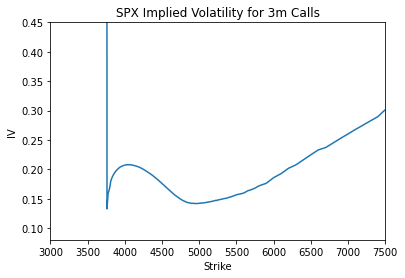

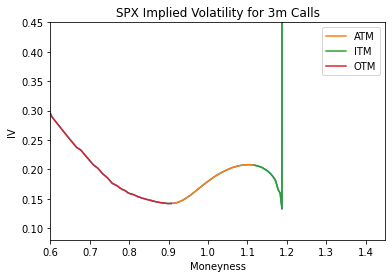

In [10]:
fig, ax = plt.subplots()
ax.plot(strikes_3m, ivs_3m)
ax.set(xlim=(3000, 7500), ylim=(.08, .45), xlabel="Strike", ylabel="IV", title="SPX Implied Volatility for 3m Calls")
plt.show()

moneyness = spx_val/strikes_3m
fig, ax = plt.subplots()
ax.plot(moneyness, ivs_3m)
ax.set(xlim=(.6, 1.45), ylim=(.08, .45), xlabel="Moneyness", ylabel="IV", title="SPX Implied Volatility for 3m Calls")

#ATM
ax.plot(moneyness[135:315], ivs_3m[135:315], label = "ATM")
#ITM
ax.plot(moneyness[0:135], ivs_3m[0:135], label = "ITM")
#OTM
ax.plot(moneyness[315:], ivs_3m[315:], label = "OTM")

plt.legend()

plt.show()

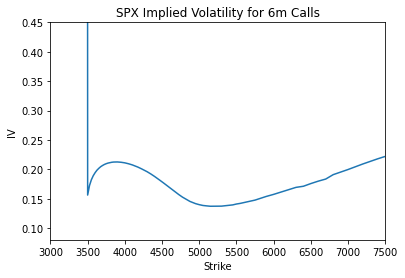

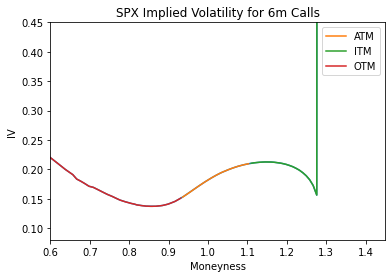

In [11]:
fig, ax = plt.subplots()
ax.plot(strikes_6m, ivs_6m)
ax.set(xlim=(3000, 7500), ylim=(.08, .45), xlabel="Strike", ylabel="IV", title="SPX Implied Volatility for 6m Calls")

moneyness = spx_val/strikes_6m
fig, ax = plt.subplots()
ax.plot(moneyness, ivs_6m)
ax.set(xlim=(.6, 1.45), ylim=(.08, .45), xlabel="Moneyness", ylabel="IV", title="SPX Implied Volatility for 6m Calls")

#ATM
ax.plot(moneyness[70:100], ivs_6m[70:100], label = "ATM")
#ITM
ax.plot(moneyness[0:70], ivs_6m[0:70], label = "ITM")
#OTM
ax.plot(moneyness[100:], ivs_6m[100:], label = "OTM")

plt.legend()
plt.show()

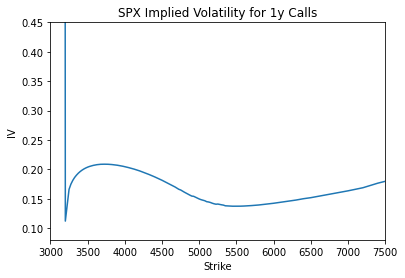

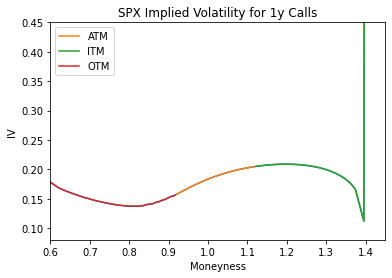

In [12]:
fig, ax = plt.subplots()
ax.plot(strikes_1y, ivs_1y)
ax.set(xlim=(3000, 7500), ylim=(.08, .45), xlabel="Strike", ylabel="IV", title="SPX Implied Volatility for 1y Calls")

moneyness = spx_val/strikes_1y
fig, ax = plt.subplots()
ax.plot(moneyness, ivs_1y)
ax.set(xlim=(.6, 1.45), ylim=(.08, .45), xlabel="Moneyness", ylabel="IV", title="SPX Implied Volatility for 1y Calls")

#ATM
ax.plot(moneyness[60:95], ivs_1y[60:95], label = "ATM")
#ITM
ax.plot(moneyness[0:60], ivs_1y[0:60], label = "ITM")
#OTM
ax.plot(moneyness[95:], ivs_1y[95:], label = "OTM")

plt.legend()

plt.show()

**(g) Comment on what happens to implied volatility when time-to-maturity increases. For a fixed maturity, comment on what happens when to implied volatility when options become ITM and OTM.**

Based on the graphs that I have produced for (3m, 6m, and 1y) maturities, it seems that the convexity of implied volatility decreases considerably as TTM increases. This makes sense because a large amount of volatility is required to move OTM options back ITM in a short period of time. 

When options with fixed maturities move ITM, it meets an inflection point and rises considerably before plateauing (along my estimates for IV at the extremes are not too accurate). When these options move OTM, their IV dips even below ATM calls. 

**(h) For the same maturities as used in (f), use the put-call parity to calculate for each call (put) option the price of the corresponding put (call). Visualize the resulting prices together with the downloaded prices of the corresponding options (if they exist). Does the put-call parity seem to hold?**

The put call parity does seem to hold. It is quite accurate compared to observed market data (at least withing 90 +/- ticks).

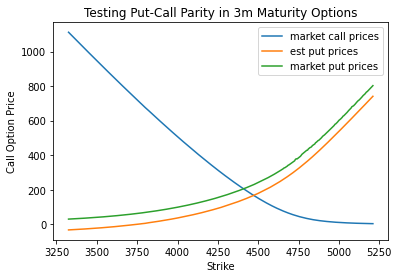

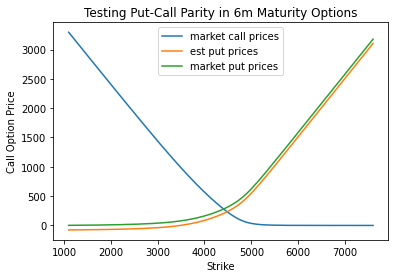

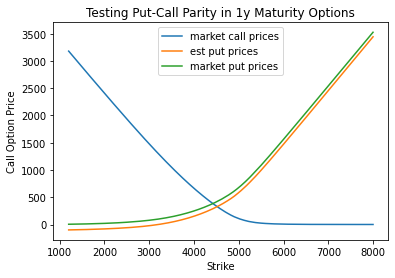

In [13]:
tau_3m = 69/252
tau_6m = 134/252
tau_1y = 264/252

# 3m p-c parity
call_prices_3m = (data_3m["Bid"] + data_3m["Ask"])/2
put_prices_3m = (data_3m["Bid.1"] + data_3m["Ask.1"])/2

est_put_prices_3m = call_prices_3m - (spx_val - data_3m["Strike"] * np.exp(-tau_3m*rf_rates["3m"]))

fig, ax = plt.subplots()
ax.plot(strikes_3m[50:350], call_prices_3m[50:350], label="market call prices")
ax.plot(strikes_3m[50:350], est_put_prices_3m[50:350], label = "est put prices")
ax.plot(strikes_3m[50:350], put_prices_3m[50:350], label = "market put prices")

ax.set(xlabel="Strike", ylabel="Call Option Price", title="Testing Put-Call Parity in 3m Maturity Options")

plt.legend()
plt.show()

# 6m p-c parity
call_prices_6m = (data_6m["Bid"] + data_6m["Ask"])/2
put_prices_6m = (data_6m["Bid.1"] + data_6m["Ask.1"])/2

est_put_prices_6m = call_prices_6m - (spx_val - data_6m["Strike"] * np.exp(-tau_6m*rf_rates["6m"]))

fig, ax = plt.subplots()
ax.plot(strikes_6m[5:350], call_prices_6m[5:350], label="market call prices")
ax.plot(strikes_6m[5:350], est_put_prices_6m[5:350], label = "est put prices")
ax.plot(strikes_6m[5:350], put_prices_6m[5:350], label = "market put prices")

ax.set(xlabel="Strike", ylabel="Call Option Price", title="Testing Put-Call Parity in 6m Maturity Options")
plt.legend()
plt.show()

# 1y p-c parity
call_prices_1y = (data_1y["Bid"] + data_1y["Ask"])/2
put_prices_1y = (data_1y["Bid.1"] + data_1y["Ask.1"])/2

est_put_prices_1y = call_prices_1y - (spx_val - data_1y["Strike"] * np.exp(-tau_1y*rf_rates["1y"]))

fig, ax = plt.subplots()
ax.plot(strikes_1y[5:350], call_prices_1y[5:350], label="market call prices")
ax.plot(strikes_1y[5:350], est_put_prices_1y[5:350], label = "est put prices")
ax.plot(strikes_1y[5:350], put_prices_1y[5:350], label = "market put prices")

ax.set(xlabel="Strike", ylabel="Call Option Price", title="Testing Put-Call Parity in 1y Maturity Options")
plt.legend()
plt.show()

**(i) For the same maturities as used in (f), plot the Black-Scholes delta and gamma as a function of strike K. Comment on the patterns you observe. Note that closed-form formulas can be used to compute the delta and gamma of call and put options in the Black-Scholes model Optional: Plot delta and gamma computed using finite-difference approximations.**

The delta of call options are almost 1 for low strikes because they are very deep ITM (changes in stock prices are 1:1 with profit). As strikes get higher, the change in the call option price becomes smaller because the option is already deep OTM and unlikely to see any gains from small movements. For short, medium, and long-term call options, we can see the delta falls more gradually the stock has more time to reach that OTM position. 

The gammas are "normal like" distributions and long maturities once again have lower overall gamma. I mentioned this above; long term calls have lower convexity. 

In [14]:
def delta(S0, r, sig, tau, K, typ):
    d1, d2 = black_scholes_d1_d2(S0, r, sig, tau, K)
    if typ == "call":
        return norm.cdf(d1)
    elif typ == "put":
        return norm.cdf(-1*d1)*-1
    else:
        return "Invalid option type"

def gamma(S0, r, sig, tau, K):
    d1, d2 = black_scholes_d1_d2(S0, r, sig, tau, K)
    return norm.pdf(d1) / (S0 * sig * np.sqrt(tau))

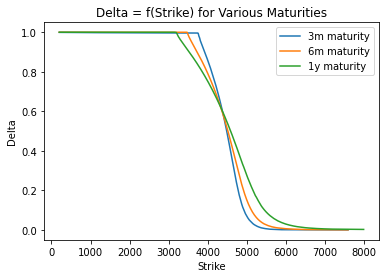

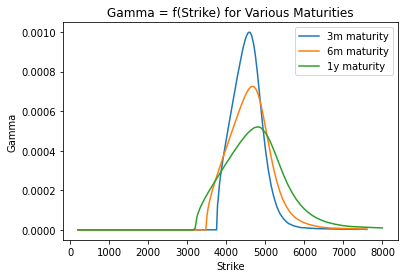

In [15]:
delta_3m = [delta(spx_val, rf_rates["3m"], ivs_3m[i], tau_3m, strikes_3m[i], typ="call") for i in range(len(strikes_3m))]
gamma_3m = [gamma(spx_val, rf_rates["3m"], ivs_3m[i], tau_3m, strikes_3m[i]) for i in range(len(strikes_3m))]

delta_6m = [delta(spx_val, rf_rates["6m"], ivs_6m[i], tau_6m, strikes_6m[i], typ="call") for i in range(len(strikes_6m))]
gamma_6m = [gamma(spx_val, rf_rates["6m"], ivs_6m[i], tau_6m, strikes_6m[i]) for i in range(len(strikes_6m))]

delta_1y = [delta(spx_val, rf_rates["1y"], ivs_1y[i], tau_1y, strikes_1y[i], typ="call") for i in range(len(strikes_1y))]
gamma_1y = [gamma(spx_val, rf_rates["1y"], ivs_1y[i], tau_1y, strikes_1y[i]) for i in range(len(strikes_1y))]

fig, ax = plt.subplots()
ax.plot(strikes_3m, delta_3m, label = "3m maturity")
ax.plot(strikes_6m, delta_6m, label = "6m maturity")
ax.plot(strikes_1y, delta_1y, label = "1y maturity")
ax.set(xlabel="Strike", ylabel="Delta", title="Delta = f(Strike) for Various Maturities")

plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(strikes_3m, gamma_3m, label = "3m maturity")
ax.plot(strikes_6m, gamma_6m, label = "6m maturity")
ax.plot(strikes_1y, gamma_1y, label = "1y maturity")
ax.set(xlabel="Strike", ylabel="Gamma", title="Gamma = f(Strike) for Various Maturities")

plt.legend()
plt.show()

***
## Problem 2

**(a) Write pseudocode for using the bisection method and Newton’s method to compute the square root of a positive number a.**

**Bisection method:** 

Let $\sqrt{a}$ = $x$. Then our objective function will be $f(x) = x^2 -a$

The first challenge is picking a lower ($l$) and upper bound ($h$) that straddles $x$.

From high school mathematics, we recall that Harmonic Mean $<=$ Geometric Mean $<=$ Arithmetic Mean for any two numbers $j$ and $k$. Let $j = a$ and $k = 1$.

$$\frac{2}{\frac{1}{a} + 1} < \sqrt{a \times 1} < \frac{a+1}{2}$$
$$f(\frac{2}{\frac{1}{a} + 1}) < 0 < f(\frac{a+1}{2})$$


Now we have our lower and upper bounds. Lets move to the pseudocode.

```
function f(x,a):
    return x^2 - a

function sqrt_bisection(a, err):
    lower := 2/(1/a + 1)
    upper := (a+1)/2

    while |upper - lower| > err:
        midpnt = (lower + upper)/2
        if f(midpnt)f(lower) < 0:
            upper = midpnt
        else:
            lower = midpnt
    return average(lower, upper)
```

**Newton's Method**

The first step is to select a random $x_0 \in (\frac{2}{\frac{1}{a} + 1}, \frac{a+1}{2})$. Then we start gradient descent:
$$
x' = x - \frac{f(x)}{f'(x)}, f'(x) = 2x
$$

From this point, we can go straight to pseudocode.

```
function f(x,a):
    return x^2 - a

function sqrt_newton(a, err):
    lower := 2/(1/a + 1)
    upper := (a+1)/2

    x0 = rand_in_range(lower, upper)
    f0 = f(x0)
    f' = 2*x0
    delta = f0/f'

    while |delta| > err:
        x1 = x0 - delta
        delta = f(x1)/f'(x1)
    
    return x

```

**(b) Implement your procedures in part (a) with tolerance $\epsilon$ = $10^{-6}$. Which one seems to require a larger number of iterations to converge?**

We can clearly see that Newton's method converges much quicker than bisection method. 

In [16]:
# objective function
def obj_func(x, a):
    return x**2 - a

# derivative of objective function
def obj_func_prime(x):
    return 2*x

# bisection method
def sqrt_bisection(a, e):
    lower = 2/(1/a + 1)
    upper = (a+1)/2

    track_iter = 0

    while np.abs(upper - lower) > e:
        midpnt = (lower + upper)/2
        if obj_func(midpnt, a) * obj_func(lower, a) < 0:
            upper = midpnt
        else:
            lower = midpnt
        
        track_iter += 1

    return (np.mean([lower, upper]), track_iter)

# Newton method
def sqrt_newton(a, e):
    lower = 2/(1/a + 1)
    upper = (a+1)/2

    track_iter = 0

    x = np.random.uniform(lower, upper)
    f = obj_func(x, a)
    f_prime = obj_func_prime(x)

    delta = f/f_prime

    while np.abs(delta) > e:
        x = x - delta
        delta = obj_func(x, a)/obj_func_prime(x)
        track_iter += 1
    return (x, track_iter)

a = sqrt_bisection(10000000, 10**-6)
b = sqrt_newton(10000000, 10**-6)

print("Num Iterations (Bisection): ", a[1])
print(a[0])
print("Num iterations (Newton): ", b[1])
print(b[0])

Num Iterations (Bisection):  43
3162.277660334772
Num iterations (Newton):  14
3162.2776601683795


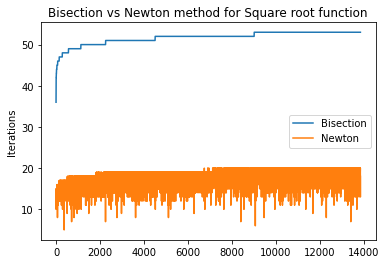

In [17]:
xr = np.arange(7**6, 7**12, 10**6)
y_bs = [sqrt_bisection(num, 10**-6)[1] for num in xr]
y_nw = [sqrt_newton(num, 10**-6)[1] for num in xr]

fig, ax = plt.subplots()
ax.plot(y_bs, label = "Bisection")
ax.plot(y_nw, label = "Newton")
ax.set(ylabel="Iterations", title="Bisection vs Newton method for Square root function")

plt.legend()

plt.show()